In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
# train = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
# test = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')

In [4]:
train.keys()

Index(['row_id', 'body', 'rule', 'subreddit', 'positive_example_1',
       'positive_example_2', 'negative_example_1', 'negative_example_2',
       'rule_violation'],
      dtype='object')

In [5]:
def extract_examples_data(df):
    example_col = [s for s in df.keys() if 'example' in s]
    example_df = df[example_col].melt(
        value_vars=example_col,
        var_name='col',
        value_name='body'
    )
    example_df['rule_violation'] = 0 if 'neg' in example_df['col'] else 1
    example_df = example_df.drop('col', axis=1)
    return example_df

In [6]:
train_example = extract_examples_data(train)
test_example = extract_examples_data(test)

# combine example dfs with training df
train_data = pd.concat([train[['body', 'rule_violation']], train_example, test_example], axis=0)

# split into training and testing data
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42) 

# transform into list of dictionary where each have keys body and rule_violation
train_data = train_data.to_dict(orient='records') 
test_data = test_data.to_dict(orient='records') 

In [7]:
def basic_tokenizer(text):
    text = text.lower()
    return re.findall(r"\b\w+\b", text)

def build_vocab(data, min_freq=1):
    freq = {}
    for d in data:
        for token in basic_tokenizer(d["body"]):
            freq[token] = freq.get(token, 0) + 1
    vocab = {"<unk>": 0, "<pad>": 1}
    for word, count in freq.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(train_data)
print("Vocab size:", len(vocab))

Vocab size: 8187


In [8]:
# text transformation: raw text -> tokens -> vocab indeces -> tensor
def text_transform(text, vocab):
    tokens = basic_tokenizer(text)
    indices = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
    return torch.tensor(indices, dtype=torch.int64)

In [10]:
# create datasets and dataloaders
def batching(batch):
    texts, labels=[],[]
    for sample in batch:
        processed_text = text_transform(sample['body'], vocab)
        texts.append(processed_text)
        labels.append(sample['rule_violation'])

    # pad to equal length
    texts = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels, dtype=torch.float32)
    return texts, labels

# split training data into training and testing data
train_loader = DataLoader(train_data, batch_size=32, collate_fn=batching)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=batching)

In [11]:
# define NN
class RuleClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1) # mean pooling
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [12]:
# train model
model = RuleClassifier(len(vocab))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    try:
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        epoch_loss = total_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch}, Loss: {total_loss:.4f}')
    except Exception as e:
        print('iter error:', e)

Epoch 0, Loss: 97.3286
Epoch 1, Loss: 84.0935
Epoch 2, Loss: 81.4851
Epoch 3, Loss: 79.8441
Epoch 4, Loss: 78.6440
Epoch 5, Loss: 76.8966
Epoch 6, Loss: 75.2610
Epoch 7, Loss: 72.8034
Epoch 8, Loss: 69.4112
Epoch 9, Loss: 65.8145
Epoch 10, Loss: 63.0232
Epoch 11, Loss: 61.1228
Epoch 12, Loss: 59.2464
Epoch 13, Loss: 58.1325
Epoch 14, Loss: 57.1884
Epoch 15, Loss: 55.9295
Epoch 16, Loss: 55.6439
Epoch 17, Loss: 54.9699
Epoch 18, Loss: 54.5032
Epoch 19, Loss: 53.6984
Epoch 20, Loss: 53.1783
Epoch 21, Loss: 54.1232
Epoch 22, Loss: 52.9141
Epoch 23, Loss: 53.1754
Epoch 24, Loss: 52.4249
Epoch 25, Loss: 51.7703
Epoch 26, Loss: 52.4479
Epoch 27, Loss: 51.3003
Epoch 28, Loss: 51.4346
Epoch 29, Loss: 51.1140
Epoch 30, Loss: 50.9048
Epoch 31, Loss: 50.0598
Epoch 32, Loss: 49.5231
Epoch 33, Loss: 49.8805
Epoch 34, Loss: 49.4395
Epoch 35, Loss: 49.1205
Epoch 36, Loss: 48.9489
Epoch 37, Loss: 48.6746
Epoch 38, Loss: 48.7507
Epoch 39, Loss: 48.1406
Epoch 40, Loss: 48.7142
Epoch 41, Loss: 48.3030
Ep

In [13]:
# evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
print(f'Accuracy: {correct / total:.2%}')

Accuracy: 88.51%


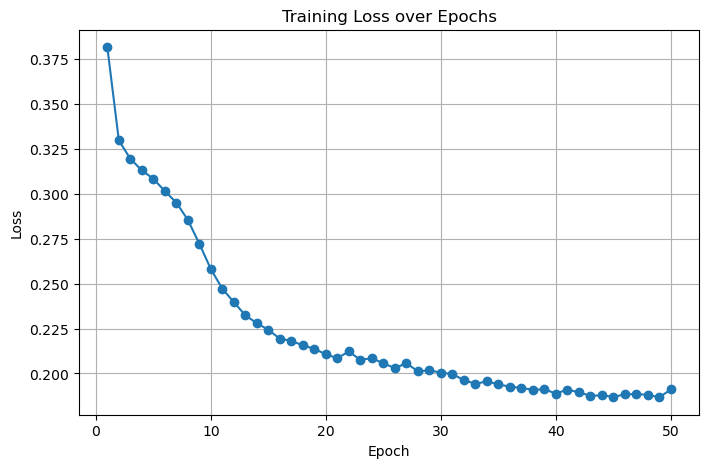

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [17]:
# make prediction
test_df = test[['body']].to_dict(orient='records') 

# Apply text_transform to each sample
processed_texts = [text_transform(item["body"], vocab) for item in test_df]
batch_inputs = torch.nn.utils.rnn.pad_sequence(processed_texts, batch_first=True, padding_value=vocab["<pad>"])

In [18]:
model.eval()
with torch.no_grad():
    outputs = model(batch_inputs)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

In [19]:
submission = pd.DataFrame({'row_id': test['row_id'], 'rule_violation': preds.numpy()})
submission.to_csv('./submission.csv')
# y_submit.to_csv('/kaggle/working/submission.csv')